In [1]:
import matplotlib.image as mpimg
from helper import *
%matplotlib inline

# Load Images

In [2]:
car_images = glob.glob('vehicles/*.png')
noncar_images = glob.glob('non-vehicles/*.png')
print ("Total number of car images: %d\nTotal number of non-car images: %d \n" %(len(car_images),len(noncar_images)))

Total number of car images: 975
Total number of non-car images: 5068 



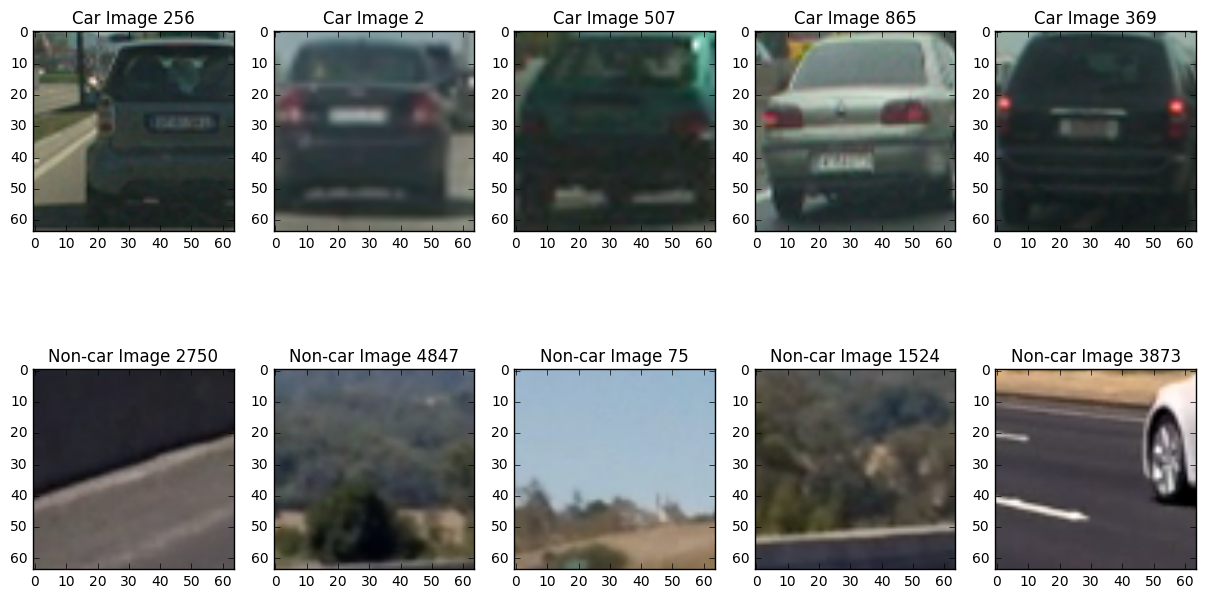

In [3]:
plt.figure(figsize=(15,8))

for i in range(5):
    car_ind = np.random.randint(0, len(car_images))
    notcar_ind = np.random.randint(0, len(noncar_images))
    
    car_image = mpimg.imread(car_images[car_ind])
    notcar_image = mpimg.imread(noncar_images[notcar_ind])

    plt.subplot(2,5,i+1)
    plt.imshow(car_image)
    plt.title('Car Image ' + str(car_ind))
    plt.subplot(2,5,5+i+1)
    plt.imshow(notcar_image)
    plt.title('Non-car Image ' + str(notcar_ind))

# Feature extraction parameters

In [4]:
global colorspace 
global hog_channel
global orient 
global pix_per_cell
global cell_per_block


colorspace= 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient= 12 
pix_per_cell = 16 
cell_per_block =2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# HOG Image

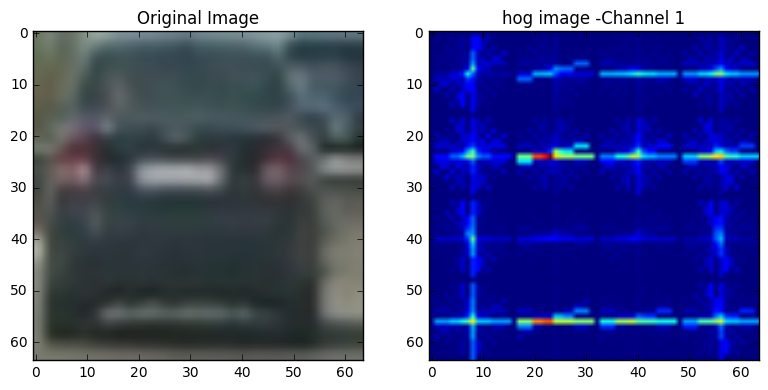

In [5]:
hog_rand_img = mpimg.imread(car_images[0])
features, hog_image = get_hog_features(hog_rand_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
plt.figure(figsize=(40,40))
plt.subplot(181)
plt.title('Original Image')
plt.imshow(hog_rand_img)
plt.subplot(182)
plt.title('hog image -Channel 1')
plt.imshow(hog_image)

# Extract features from images

In [6]:
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Number of Feature Extracted 

In [7]:
print ("Total Number of Feature used in a model :" , len(car_features[0]))

Total Number of Feature used in a model : 1296


# Shuffle and Split the data into training and test data

In [8]:
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Use a linear Support Vector Classfier to classify the image 

In [9]:
from sklearn.svm import SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


0.54 Seconds to train SVC
Test Accuracy of SVC =  0.9959


In [10]:
print('Predicted value = ', svc.predict(X_test[0:5]))
print ('Actual Value = ',y_test[0:5])

Predicted value =  [ 0.  1.  0.  1.  0.]
Actual Value =  [ 0.  1.  0.  1.  0.]


# Identify vehicle from the Image

In [13]:
def draw_img(img):
    rectangles=[]
#     ystart = 400
#     ystop = 464
#     hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#     for counter in range (3): 
#         for i in range (10):
#             ystop = 480 + (18*i)
#             scale = counter + 0.5fdfdfznslkeandlkn
#             rectangles.append (find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
#                                orient, pix_per_cell, cell_per_block, None,None))


    
    ystart = 400
    ystop = 660
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 660
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    
    ystart = 400
    ystop = 660
    scale = 2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))



    
    rectangles = [item for sublist in rectangles for item in sublist] 
    draw_img = draw_boxes(np.copy(img), rectangles, thick=2)    
    return (draw_img,rectangles)

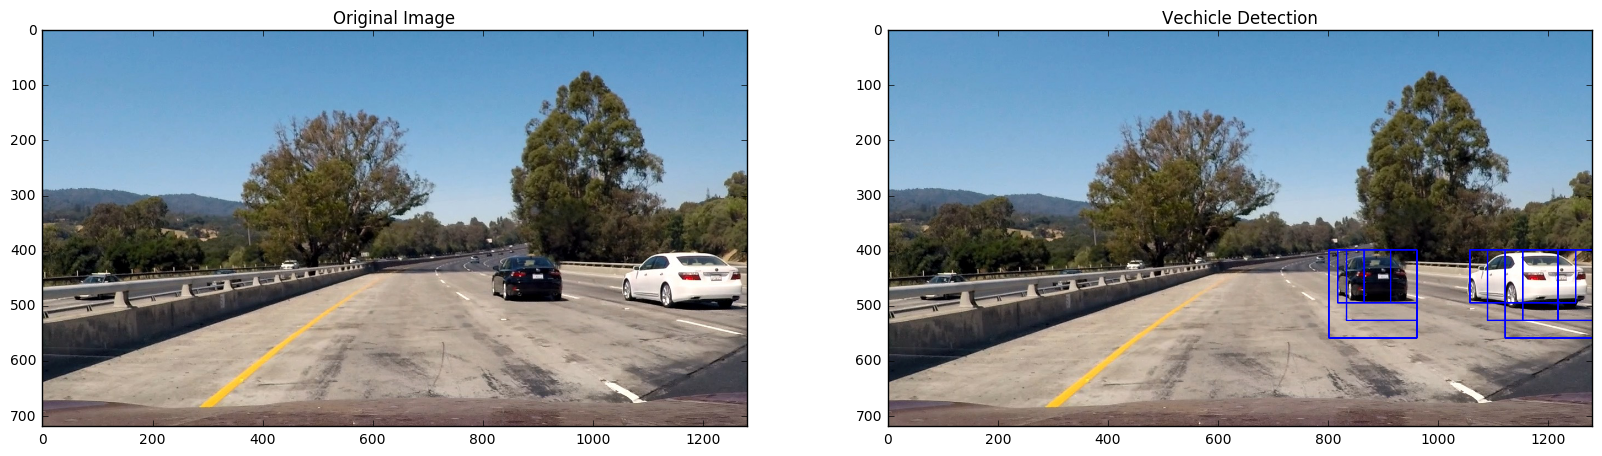

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image')
test_img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(test_img)
plt.subplot(122)
plt.title('Vechicle Detection')
draw_box,rectangles= draw_img(test_img)
plt.imshow(draw_box)


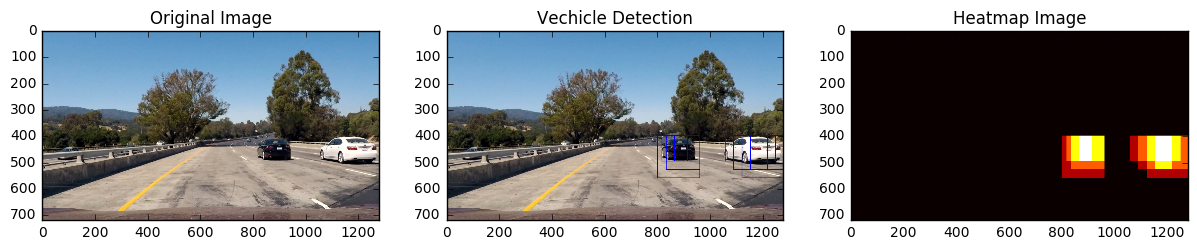

In [15]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Original Image')
plt.imshow(test_img)
plt.subplot(142)
plt.title('Vechicle Detection')
plt.imshow(draw_box)
plt.subplot(143)
plt.title('Heatmap Image')
plt.imshow(heatmap_img, cmap='hot')

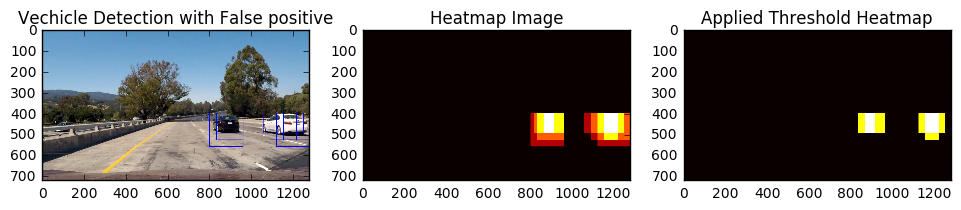

In [19]:
threshold_heatmap_img = apply_threshold(np.copy(heatmap_img),2)
plt.figure(figsize=(20,20))
plt.subplot(151)
plt.title('Vechicle Detection with False positive')
plt.imshow(draw_box)
plt.subplot(152)
plt.title('Heatmap Image')
plt.imshow(heatmap_img, cmap='hot')
plt.subplot(153)
plt.title('Applied Threshold Heatmap')
plt.imshow(threshold_heatmap_img, cmap='hot')


2 cars found


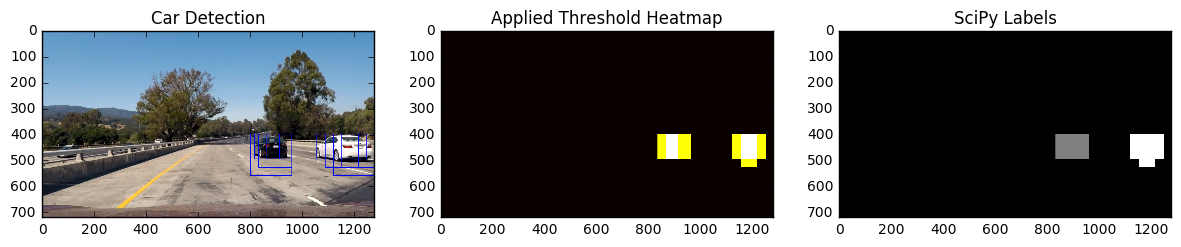

In [20]:

labels = label(threshold_heatmap_img)

plt.figure(figsize=(30,30))
plt.subplot(161)
plt.title('Car Detection')
plt.imshow(draw_box)
plt.subplot(162)
plt.title('Applied Threshold Heatmap')
plt.imshow(threshold_heatmap_img, cmap='hot')
plt.subplot(163)
plt.title('SciPy Labels')
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

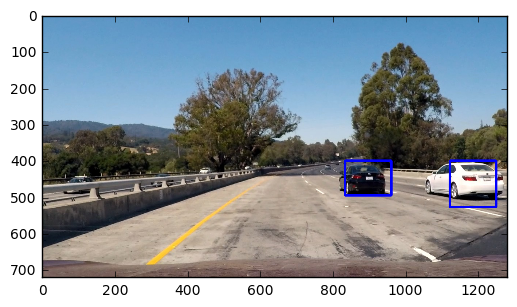

In [21]:
draw_img, rects = draw_labeled_bboxes(np.copy(test_img), labels)
plt.imshow (draw_img)

In [25]:
def pipeline_image(img):
    
    rectangles=[]


    
    ystart = 400
    ystop = 660
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 660
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 660
    scale = 2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img



In [26]:
# Define a class to store data from video
## This logic is taken from Harish Vadlamani 

class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

# VideoStream Pipeline

In [27]:
det = Vehicle_Detect()
from moviepy.editor import VideoFileClip
proj_out_file = 'project_video_output.mp4'
clip_proj = VideoFileClip('project_video.mp4') 
clip_proj_out = clip_proj.fl_image(pipeline_image)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:03<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 6s
